In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [9]:
class ReplayMemory():
    def __init__(self):
        self.memory = torch.zeros((1, 210, 160, 3))

    def append(self, instance):
        if torch.any(self.memory):
            self.memory = torch.cat((self.memory, instance), 0)
        else:
            self.memory[0] = instance

    def downsize(self):
        self.downsizememory = self.memory.permute(0, 3, 1, 2)
        self.downsizememory = self.downsizememory.mean(1, True)
        self.downsizememory = F.interpolate(self.downsizememory, (80, 70), mode='bilinear', align_corners=False)


replaymemory = ReplayMemory()

In [11]:
env = gym.make("ALE/Alien-v5", obs_type="rgb", frameskip=5)
observation, info = env.reset()

for i in range(100):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print(reward)
    replaymemory.append(torch.tensor(observation).unsqueeze(0))
    
    if terminated or truncated:
        observation, info = env.reset()

env.close()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
10.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
10.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
10.0
0.0
0.0
0.0
0.0
0.0


In [95]:
env.action_space.n

np.int64(6)

In [4]:
replaymemory.downsize()

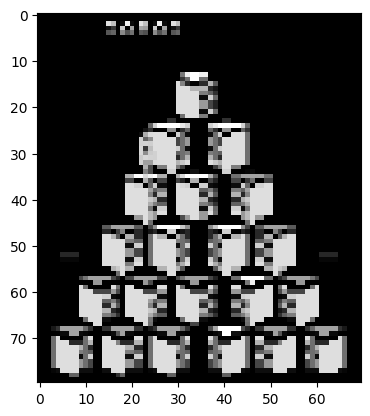

In [5]:
replaymemory.downsize()
plt.figure()
plt.imshow(replaymemory.downsizememory[300, 0], interpolation='none', cmap="gray")
plt.show()

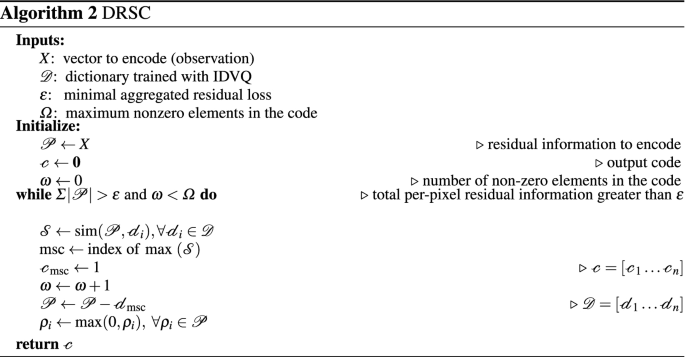

In [76]:
# def DRSC(P, dictionary, epsilon=0.005, omega=4):
#     print("------NEW------")
#     o = torch.zeros(dictionary.shape[0])
#     w = 0

#     while torch.sum(P) / 5600 > epsilon and w < omega:
#         S = torch.norm(dictionary - P.unsqueeze(0), dim=1)  # Use norm instead of sum
#         msc = torch.argmin(S)
#         print('msc', msc.item())
        
#         o[msc] = 1
#         w += 1
#         P = P - dictionary[msc]
#         F.relu(P, inplace=True)
#         print('sum(P)', torch.sum(P).item())

#     return o

def DRSC(P, dictionary, epsilon=0.005, omega=4):
    o = torch.zeros(dictionary.shape[0])
    w = 0

    while torch.sum(P) / 5600 > epsilon and w < omega:
        S = torch.norm(dictionary - P.unsqueeze(0), dim=1)  # Use norm instead of sum
        msc = torch.argmin(S)
        
        o[msc] = 1
        w += 1
        P = P - dictionary[msc]
        F.relu(P, inplace=True)
    return o

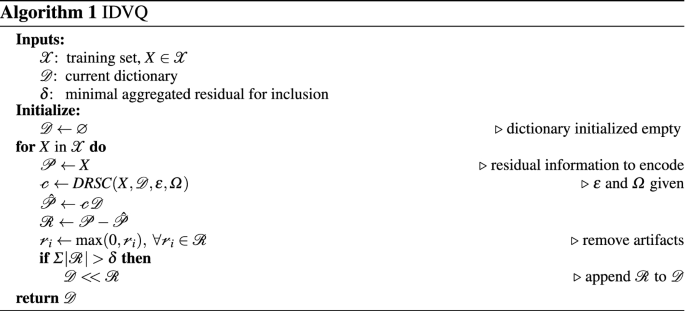

In [82]:
def IDVQ(training_set, current_dictionairy, threshold=0.00495):
    for image in training_set:
        P = torch.flatten(image) / 255
        if current_dictionairy is None:
            current_dictionairy = P.unsqueeze(0)
            threshold = threshold * P.numel()
        else:
            o = DRSC(P, current_dictionairy)
            P_hat = current_dictionairy.T @ o
            R = (P - P_hat)
            torch.nn.functional.relu(R, inplace=True)
            if torch.sum(R) > threshold:
                current_dictionairy = torch.cat((current_dictionairy, R.unsqueeze(0)), dim=0)
    print("dictionairy size: ", current_dictionairy.shape[0])
    return current_dictionairy

In [83]:
new_dictionairy = IDVQ(replaymemory.downsizememory, None)

dictionairy size:  11


In [144]:
class Controller(nn.Module):
    def __init__(self, env):
        super(Controller, self).__init__()
        self.input_size = 1
        self.num_actions = env.action_space.n
        self.Rweights = nn.Parameter(torch.zeros((self.num_actions, self.num_actions)))
        self.Iweights = nn.Parameter(torch.zeros(1, self.num_actions))
        self.register_buffer('prev_x', torch.zeros(self.num_actions))
        self.bias = torch.ones(self.num_actions)
    
    def forward(self, x, dictionary):
        if not self.input_size == dictionary.shape[0]:
            self.rebuild_network(dictionary)
        self.prev_x = self.Iweights.T @ x + self.Rweights @ self.prev_x + self.bias
        return self.prev_x
        
    def rebuild_network(self, dictionary):
        neurons_to_add = dictionary.shape[0] - self.input_size
        new_Iweights = nn.Parameter(torch.cat((self.Iweights, torch.zeros(neurons_to_add, self.num_actions))))
        self.Iweights = new_Iweights
        self.input_size += neurons_to_add

In [151]:
def test1():
    agent = Controller(env)
    feature_vec = torch.ones(1)
    dictionary = torch.rand(1, 5600)
    action = agent.forward(feature_vec, dictionary)
    return action

def test2():
    agent = Controller(env)
    feature_vec = torch.ones(1)
    dictionary = torch.rand(1, 5600)
    action = agent.forward(feature_vec, dictionary)
    feature_vec = torch.ones(4)
    dictionary = torch.rand(4, 5600)
    action = agent.forward(feature_vec, dictionary)
    return action

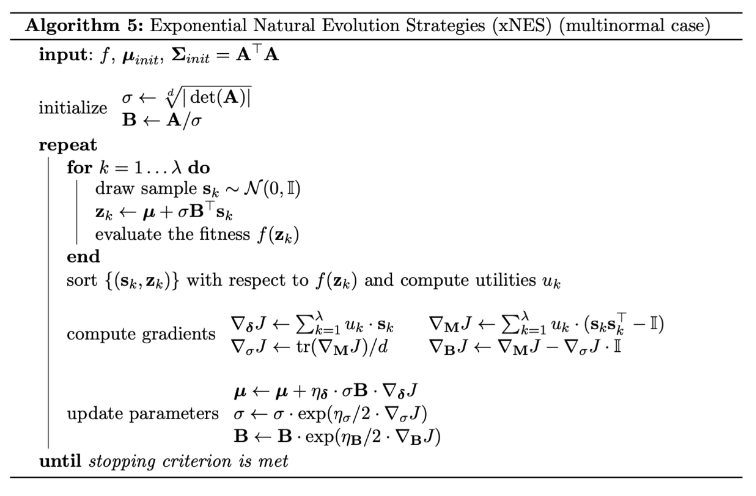

In [ ]:
def xNES(f, u_init, Sigma_init, population_size, lr_u, lr_s, lr_b, num_generations):
    # Initialise 
    d = u_init.numel()
    u = u_init.clone()
    A = torch.linalg.cholesky(Sigma_init)
    sigma = torch.pow(torch.abs(torch.linalg.det(A)), 1 / d)
    B = A / sigma
    normal_distribution = torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))

    for generation in range(num_generations):
        # Sampling from search distribution
        samples = []
        for k in range(population_size):
            sk = normal_distribution.sample()
            zk = u + sigma * B.T @ sk
            samples.append((sk, zk))
        
        # Fitness evaluation and utility assignment
        sorted_samples = sorted(samples, key=lambda tup: f(tup[1]))
        utilities = torch.tensor([max(0, torch.log(torch.tensor(population_size / 2 + 1)) - torch.log(torch.tensor(rank + 1))) for rank in range(population_size)])
        utilities = utilities / utilities.sum() - 1 / population_size

        # Gradients calculation
        grad_d = torch.zeros(d)
        grad_m = torch.zeros(d, d)

        for i, (sk, _) in enumerate(sorted_samples):
            uk = utilities[i]
            grad_d += uk * sk
            grad_m += uk * (sk.unsqueeze(1) @ sk.unsqueeze(0) - torch.eye(d))
        
        grad_s = torch.trace(grad_m) / d
        grad_b = grad_m - grad_s * torch.eye(d)

        # Parameters update
        u = u + lr_u * sigma * B @ grad_d
        sigma = sigma * torch.exp(lr_s / 2 * grad_s)
        B = B @ torch.linalg.matrix_exp(lr_b / 2 * grad_b)
    
    return u

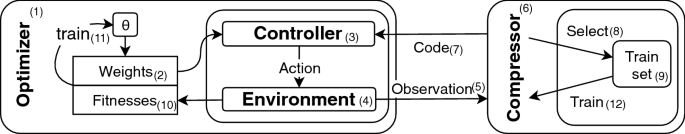

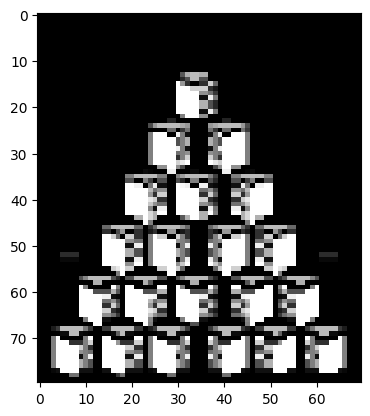

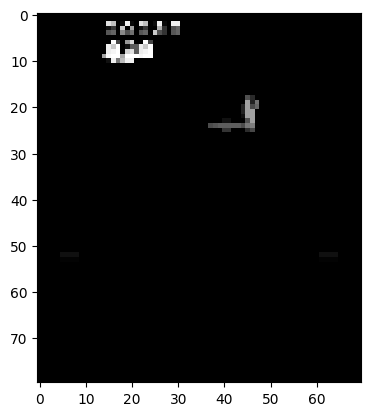

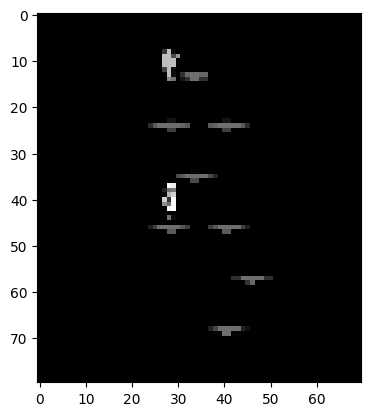

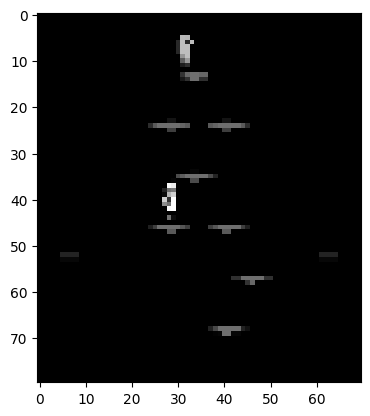

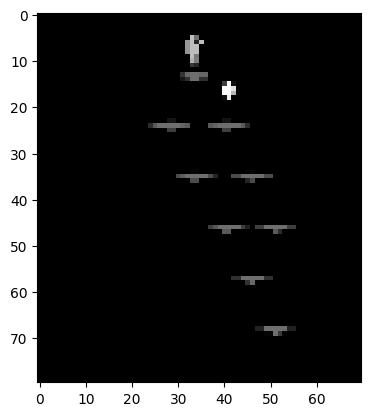

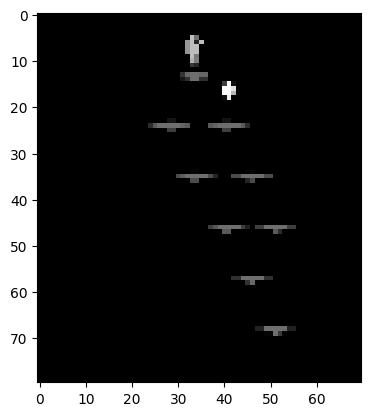

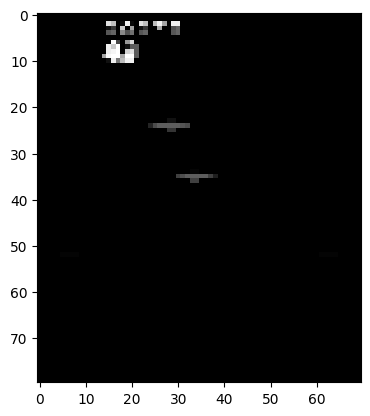

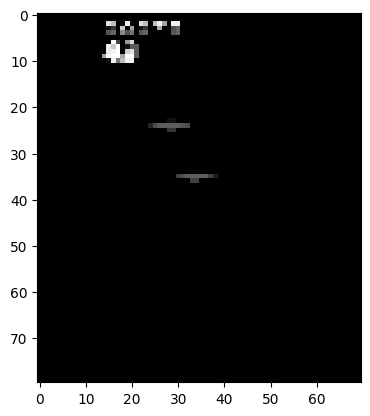

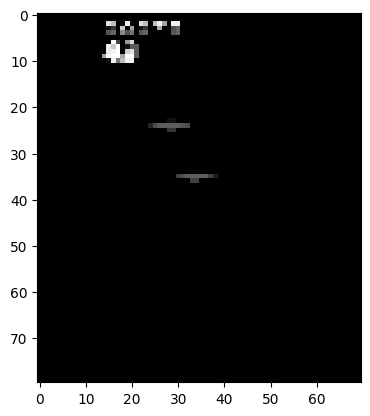

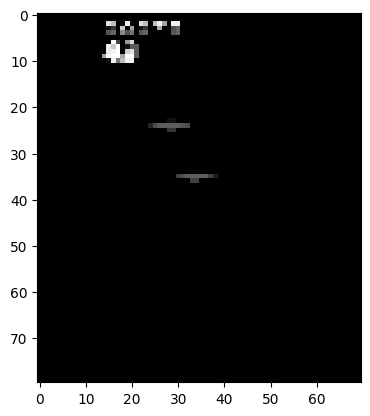

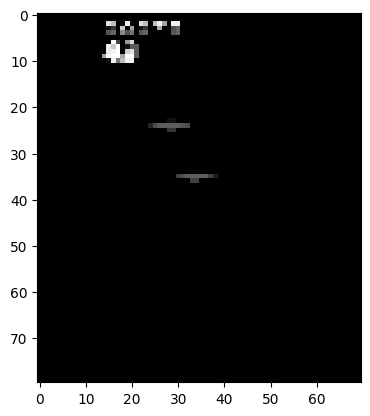

In [84]:
for i in range(new_dictionairy.shape[0]):
    plt.figure()
    plt.imshow(new_dictionairy[i].reshape((80,70)), interpolation='none', cmap="gray")
    plt.show()